In [138]:
# import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mplt
import numpy as np
import pandas as pd 
import os
import shapely as shp
import shutil

# enable mutiple outputs per notebook cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set style for plots
plt.style.use('classic')

In [123]:
# specify AoI
aoi = "upper_rhine" #"magdeburger_boerde" #"coastal_landscape"

# specify working dir
workdir = "C:/Users/felix/github/field_boundary_delineation"

# copy delineated field file from ecognition workspace into corresponding sample data folder
ecog_dir = os.path.join(
    workdir, 
    "ecognition_workspace", 
    "results", 
    "ObjectShapes", 
    f"{aoi}.x.subsets.Subset")

sample_dir = os.path.join(workdir, "sample_data", aoi)

src_files = os.listdir(ecog_dir)
for file_name in src_files:
    full_file_name = os.path.join(ecog_dir, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, os.path.join(sample_dir, "results"))

'C:/Users/felix/github/field_boundary_delineation\\sample_data\\upper_rhine\\results\\fields.dbf'

'C:/Users/felix/github/field_boundary_delineation\\sample_data\\upper_rhine\\results\\fields.prj'

'C:/Users/felix/github/field_boundary_delineation\\sample_data\\upper_rhine\\results\\fields.shp'

'C:/Users/felix/github/field_boundary_delineation\\sample_data\\upper_rhine\\results\\fields.shx'

In [124]:
# read fields delineated via application as well as manually delineated validation fields
fields_dir = os.path.join(sample_dir, "results", "fields.shp")
fields_val_dir = os.path.join(sample_dir, "manually_delineated_fields", f"{aoi}_validation.shp") 

fields = gpd.read_file(fields_dir)
fields_val = gpd.read_file(fields_val_dir)

In [125]:
# spatial join - match delineated and validation fields
fields_intersect = fields_val.sjoin(fields, how="left")[["geometry", "index_right"]]
fields_intersect = fields_intersect.rename(columns = {"geometry": "geom_fields_val", "index_right" : "idx_fields"})
fields_intersect = pd.merge(fields_intersect, fields, left_on="idx_fields", right_index=True)
fields_intersect = fields_intersect.reset_index()
fields_intersect = fields_intersect.rename(columns = {"geometry": "geom_fields", "index": "idx_fields_val"})
fields_intersect = fields_intersect[["idx_fields_val", "geom_fields_val", "idx_fields", "geom_fields"]]

if fields_intersect["idx_fields_val"].nunique() < len(fields_val):
    missing_fields = len(fields_val)-fields_intersect['idx_fields_val'].nunique()
    print(f"Warning: For {missing_fields} validation field(s) no overlapping segmented fields were found.")

In [126]:
# calculate areal overlap measures to find best matching segemented fields
# determine overlaps relative to validation fields & segmented fields
# additionally intersection over union (aka Jaccard-Index)
overlaps_val = []
overlaps_seg = []
overlaps_IoU = []

for index, row in fields_intersect.iterrows():
    field_val_geom = shp.geometry.shape(row["geom_fields_val"])
    field_geom = shp.geometry.shape(row["geom_fields"])
    fields_union = field_val_geom.union(field_geom)
    overlaps_val.append((field_val_geom.intersection(field_geom).area/field_val_geom.area)*100)
    overlaps_seg.append((field_geom.intersection(field_val_geom).area/field_geom.area)*100)
    overlaps_IoU.append((field_geom.intersection(field_val_geom).area/fields_union.area)*100)

fields_intersect["ov_val"] = overlaps_val
fields_intersect["ov_seg"] = overlaps_seg
fields_intersect["ov_combined"] = (fields_intersect["ov_seg"] + fields_intersect["ov_val"])/2
fields_intersect["ov_IoU"] = overlaps_IoU

# filter delineated fields with maximum overlap for each validation field
idx_max_overlap = fields_intersect.groupby(['idx_fields_val'])['ov_combined'].transform(max) == fields_intersect["ov_combined"]
fields_intersect = fields_intersect[idx_max_overlap].reset_index(drop=True)

fields_intersect.head(5)

,idx_fields_val,geom_fields_val,idx_fields,geom_fields,ov_val,ov_seg,ov_combined,ov_IoU
0,0,"POLYGON ((399670.269 5316421.831, 399879.463 5...",5276.0,"POLYGON ((400000.000 5316010.000, 399990.000 5...",69.096641,41.338123,55.217382,34.887905
1,1,"POLYGON ((400569.020 5315977.524, 400559.968 5...",5013.0,"POLYGON ((400720.000 5315960.000, 400720.000 5...",66.542722,97.520100,82.031411,65.435452
2,2,"POLYGON ((401359.237 5312708.041, 401225.280 5...",7211.0,"POLYGON ((401440.000 5312780.000, 401420.000 5...",55.242942,98.262913,76.752927,54.708667
3,3,"POLYGON ((401142.827 5317978.821, 401149.067 5...",4097.0,"POLYGON ((401450.000 5318060.000, 401440.000 5...",86.632914,28.272834,57.452874,27.091021
4,4,"POLYGON ((399853.536 5312241.982, 399924.592 5...",7584.0,"POLYGON ((399950.000 5312190.000, 399940.000 5...",86.253642,95.221060,90.737351,82.674748


In [127]:
# calculate additional accuracy measures (edge-based)
# define function to calculate mae error
def points_along_boundary(geom, dist=2.5):
    distance_delta = dist
    distances = np.arange(0, geom.length, distance_delta)
    points = [geom.exterior.interpolate(distance) for distance in distances]
    multipoint = shp.ops.unary_union(points)
    return multipoint

def mean_absolute_edge_error(source_geom, replica_geom):
    dists = []
    for ref_point in source_geom.geoms:
        near_points = shp.ops.nearest_points(ref_point, replica_geom)
        dists.append(near_points[0].distance(near_points[1]))
    return np.mean(np.array(dists))

# initialise empty lists
hausdorff_dists = []
mae_val_dists = []
mae_seg_dists = []

# calculate edge-based metrics for all fields
for index, row in fields_intersect.iterrows():
    field_val_geom = shp.geometry.shape(row["geom_fields_val"])
    field_geom = shp.geometry.shape(row["geom_fields"])
    mae_val_dist = mean_absolute_edge_error(
        points_along_boundary(field_val_geom),
        points_along_boundary(field_geom)
        )
    mae_seg_dist = mean_absolute_edge_error(
        points_along_boundary(field_geom),
        points_along_boundary(field_val_geom)
        )
    mae_val_dists.append(mae_val_dist)
    mae_seg_dists.append(mae_seg_dist)
    hausdorff_dists.append(field_geom.hausdorff_distance(field_val_geom))

fields_intersect["mae_val"] = mae_val_dists
fields_intersect["mae_seg"] = mae_seg_dists
fields_intersect["mae_combined"] = fields_intersect["mae_val"] + fields_intersect["mae_seg"]
fields_intersect["hausdorff_dist"] = hausdorff_dists
fields_intersect.head(5)

,idx_fields_val,geom_fields_val,idx_fields,geom_fields,ov_val,ov_seg,ov_combined,ov_IoU,mae_val,mae_seg,mae_combined,hausdorff_dist
0,0,"POLYGON ((399670.269 5316421.831, 399879.463 5...",5276.0,"POLYGON ((400000.000 5316010.000, 399990.000 5...",69.096641,41.338123,55.217382,34.887905,56.961182,106.780627,163.741809,268.805133
1,1,"POLYGON ((400569.020 5315977.524, 400559.968 5...",5013.0,"POLYGON ((400720.000 5315960.000, 400720.000 5...",66.542722,97.520100,82.031411,65.435452,92.917697,10.780272,103.697970,429.087586
2,2,"POLYGON ((401359.237 5312708.041, 401225.280 5...",7211.0,"POLYGON ((401440.000 5312780.000, 401420.000 5...",55.242942,98.262913,76.752927,54.708667,20.723356,17.442426,38.165782,54.533887
3,3,"POLYGON ((401142.827 5317978.821, 401149.067 5...",4097.0,"POLYGON ((401450.000 5318060.000, 401440.000 5...",86.632914,28.272834,57.452874,27.091021,3.960631,73.645060,77.605691,199.501035
4,4,"POLYGON ((399853.536 5312241.982, 399924.592 5...",7584.0,"POLYGON ((399950.000 5312190.000, 399940.000 5...",86.253642,95.221060,90.737351,82.674748,4.528084,5.539923,10.068007,16.759428


In [128]:
# summarise stats for all fields
print(f"areal stats")
print(fields_intersect.iloc[:,4:8].mean(numeric_only=True).round(2))

print(f"\nedge-based stats")
print(fields_intersect.iloc[:,8:].mean(numeric_only=True).round(2))

# plot distributions
# e.g. for IoU
# import seaborn as sns
# sns.kdeplot(fields_intersect["ov_IoU"], bw_adjust=0.2)

areal stats
ov_val         86.37
ov_seg         73.91
ov_combined    80.14
ov_IoU         64.28
dtype: float64

edge-based stats
mae_val            13.17
mae_seg            28.68
mae_combined       41.85
hausdorff_dist    101.73
dtype: float64


plotting field idx 4
plotting field idx 7


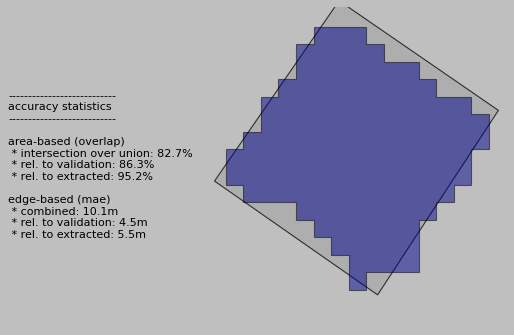

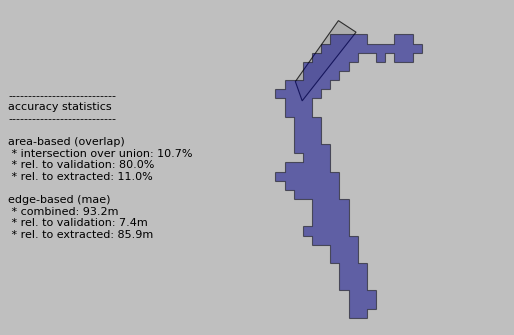

In [142]:
# plotting function - reference & validation fields
def plot_fields_acc_metrics(field_intersect_idx=15):
    idx = field_intersect_idx
    # get stats for field
    ov_val = fields_intersect.iloc[idx]['ov_val'].round(1)/100
    ov_seg = fields_intersect.iloc[idx]['ov_seg'].round(1)/100
    ov_IoU = fields_intersect.iloc[idx]['ov_IoU'].round(1)/100
    mae_val = fields_intersect.iloc[idx]['mae_val'].round(1)
    mae_seg = fields_intersect.iloc[idx]['mae_seg'].round(1)
    mae_combined = fields_intersect.iloc[idx]['mae_combined'].round(1)
    acc_stats = (
        f"---------------------------"
        f"\naccuracy statistics"
        f"\n---------------------------"
        f"\n"
        f"\narea-based (overlap)"
        f"\n * intersection over union: {ov_IoU:.1%}"
        f"\n * rel. to validation: {ov_val:.1%}"
        f"\n * rel. to extracted: {ov_seg:.1%}"
        f"\n"
        f"\nedge-based (mae)"
        f"\n * combined: {mae_combined:.1f}m"
        f"\n * rel. to validation: {mae_val:.1f}m"
        f"\n * rel. to extracted: {mae_seg:.1f}m"
        )
    # create plot
    fig = plt.figure(figsize=(7,5))
    gs  = mplt.gridspec.GridSpec(1, 2, width_ratios=[0.25,1])
    ax0 = plt.subplot(gs[0])
    ax0.axis("off")
    ax1 = plt.subplot(gs[1])
    xs1, ys1 = fields_intersect["geom_fields_val"].iloc[idx].exterior.xy
    xs2, ys2 = fields_intersect["geom_fields"].iloc[idx].exterior.xy
    ax1.fill(xs1, ys1, alpha=.75, fc='darkgrey')
    ax1.fill(xs2, ys2, alpha=.5, fc='darkblue')
    ax1.axis('equal')
    ax1.axis("off")
    plt.gcf().text(0.01, 0.325, acc_stats, fontsize=10)
    return fig;


# plot some random examples
randints = [np.random.randint(0,len(fields_intersect)) for i in range(2)]

for i, idx in enumerate(randints):
    print(f"plotting field idx {idx}")
    p1 = plot_fields_acc_metrics(idx)
    #p1.savefig(os.path.join(workdir, "documentation_figures", f"comparison_extr_val_field_{i}.png"))